In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("data_csv/by_country/INDIA.csv")

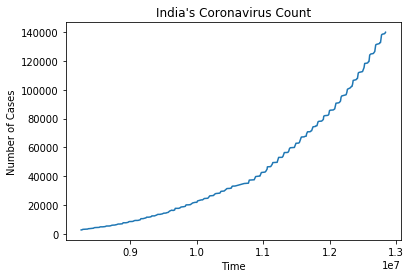

In [8]:
plt.plot(df["timestamp"],df["Confirmed Case"])
plt.xlabel("Time")
plt.ylabel("Number of Cases")
plt.title("India's Coronavirus Count")
# plt.show()
plt.savefig("results/confirmed_cases_INDIA.png")